In [60]:
using RobotZoo
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using MeshCat, GeometryBasics, Colors, CoordinateTransformations, Rotations
using Plots
using Convex
using SCS
using BilinearControl

In [61]:
include("regression.jl")
include("eigenfunctions.jl")

build_eigenfunctions (generic function with 1 method)

In [62]:
const RD = RobotDynamics

RobotDynamics

In [63]:
function defcolor(c1, c2, c1def, c2def)
    if !isnothing(c1) && isnothing(c2)
        c2 = c1
    else
        c1 = isnothing(c1) ? c1def : c1
        c2 = isnothing(c2) ? c2def : c2
    end
    c1,c2
end

function set_mesh!(vis0, model::RobotZoo.Pendulum; 
    color=nothing, color2=nothing)
    
    vis = vis0["robot"]
    dim = Vec(0.1, 0.3, 0.1)
    cart = Rect3D(-dim/2, dim)
    hinge = Cylinder(Point3f0(-dim[1]/2,0,dim[3]/2), Point3f0(dim[1],0,dim[3]/2), 0.03f0)
    c1,c2 = defcolor(color,color2, colorant"blue", colorant"red")

    pole = Cylinder(Point3f0(0,0,0),Point3f0(0,0,model.len),0.01f0)
    mass = HyperSphere(Point3f0(0,0,model.len), 0.05f0)
    setobject!(vis["cart","box"],   cart, MeshPhongMaterial(color=isnothing(color) ? colorant"green" : color))
    setobject!(vis["cart","hinge"], hinge, MeshPhongMaterial(color=colorant"black"))
    setobject!(vis["cart","pole","geom","cyl"], pole, MeshPhongMaterial(color=c1))
    setobject!(vis["cart","pole","geom","mass"], mass, MeshPhongMaterial(color=c2))
    settransform!(vis["cart","pole"], Translation(0.75*dim[1],0,dim[3]/2))
end

function visualize_state!(vis, model::RobotZoo.Pendulum, x)
    θ = x[1]
    q = expm((pi-θ) * @SVector [1,0,0])
    settransform!(vis["robot","cart","pole","geom"], LinearMap(UnitQuaternion(q)))
end

function visualize!(vis, model::RobotDynamics.AbstractModel, tf::Real, X)
    fps = Int(round((length(X)-1)/tf))
    anim = MeshCat.Animation(fps)
    n = state_dim(model)
    for (k,x) in enumerate(X)
        atframe(anim, k) do
            x = X[k]
            visualize_state!(vis, model, SVector{n}(x)) 
        end
    end
    setanimation!(vis, anim)
end

visualize! (generic function with 1 method)

In [64]:
function create_test_U(num_knots, m, U_type::String)

    if U_type == "constant"
        u0 = 2 .* ones(m)
    elseif U_type == "random"
        u0 = 0.01 .* ones(m)
    end

    U = [u0]

    for k in 1:(num_knots-1)

        if U_type == "constant"
            u = 2 .* ones(m)
        elseif U_type == "random"
            u = -5 .+ (10*rand(Float64, m))
        end

        push!(U, u)

    end
    
    return U

end

function create_training_U(num_knots, m)

    u0 = -3 .* ones(m)
    U = [u0]

    for k in 1:(num_knots-1)

        u = -3 .+ (6*rand(Float64, m))
        push!(U, u)

    end

    # for k in (Int(round((num_knots-1)/2) + 1)) : (num_knots - 1)

    #     u = 2 .* ones(m)
    #     push!(U, u)
    # end
    
    # return U

    # for k in 1 : (Int(round((num_knots-1)/2)))

    #     u = -3 .+ (6*rand(Float64, m))
    #     push!(U, u)

    # end

    # for k in (Int(round((num_knots-1)/2) + 1)) : (num_knots - 1)

    #     u = -2 .* ones(m)
    #     push!(U, u)
    # end
    
    return U

end

create_training_U (generic function with 1 method)

In [65]:
function simulate(dmodel, x0, U, dt)

    t = 0.0
    x = x0
    X = [x]
    T = [t]
    
    for k in 1:length(U)

        u = U[k]
        x = RD.discrete_dynamics(dmodel, x, u, t, dt)
        t += dt
        push!(X, x)
        append!(T, t)

    end

    return T, X

end

function simulate_bilinear(F, C, g, x0, z0, U)
    
    x = x0
    z = z0
    Z = [z]
    X = [x]

    for k in 1:length(U)

        u = U[k]
        
        z = F * z + (C * z) .* u
        x = g * z

        push!(Z, z)
        push!(X, x)
        
    end

    return X, Z

end

simulate_bilinear (generic function with 1 method)

In [66]:
# define temporal properties
dt = 0.01
tf = 3

num_knots = Int(tf/dt + 1)

# define pendulum initial properties
x0 = [0.5*pi, 0]

# define Pendulum model
model = RobotZoo.Pendulum()

state_dim(model) = 2
control_dim(model) = 1

dmodel = RD.DiscretizedDynamics{RD.RK4}(model)
n, m = RD.dims(dmodel)

(2, 1, 2)

In [67]:
# create predefined control trajectory
U_sim = create_training_U(num_knots, m)

# randomly simulate model and store trajectory
time, X_sim = simulate(dmodel, x0, U_sim, dt)

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.07, 0.08, 0.09  …  2.9199999999999817, 2.9299999999999815, 2.9399999999999813, 2.949999999999981, 2.959999999999981, 2.9699999999999807, 2.9799999999999804, 2.9899999999999802, 2.99999999999998, 3.00999999999998], [[1.5707963267948966, 0.0], [1.569217432789066, -0.31556838125925163], [1.5646803658969088, -0.5916603649712876], [1.5581345347913564, -0.7174200066911205], [1.550345495944351, -0.8403016249774741], [1.5411465841270517, -0.9993671607349741], [1.5303587776191856, -1.1580759760931425], [1.5176844902406272, -1.376616428868546], [1.5024915108922385, -1.6617592066336582], [1.484661496382685, -1.9040372024211185]  …  [0.6485826128831395, 1.5405633998404427], [0.6637084918156848, 1.4842580617406926], [0.6783892435985415, 1.4515381865393588], [0.6918077850785053, 1.2319767226164997], [0.7035432039192651, 1.114891044934854], [0.7142729497176411, 1.03084783634931], [0.7236806807845888, 0.8505870687769639], [0.7309880436461778

In [102]:
# determine eigenfunction state values
Z_sim, Zu_sim, z0 = build_eigenfunctions(X_sim, U_sim, ["state", "sine", "cosine"], [0, 0, 0])

# learn bilinear model
F, C, g = learn_bilinear_model(X_sim, Z_sim, Zu_sim, ["lasso", "lasso"]; edmd_weights=[0.0], mapping_weights=[0.0])

([1.0000000000000007 2.5125919439368266e-15 … -4.449062254597272e-16 -2.3401081782815113e-16; -1.1528230878244e-6 0.9999980196869309 … 1.1917588806822864e-6 7.337164151077003e-7; … ; 0.009083987031647627 0.014168330365883754 … 0.9897164678453169 2.5310791313660048e-5; -0.02780221234088388 -0.2546504902005071 … 0.039276933872946514 0.9895294846302161], [-6.58719936225662e-16 -7.513254915206018e-16 … 7.419851476593078e-16 1.7037522784262035e-16; 0.00019964855925607978 4.4637289719101823e-7 … 1.0916801305658908e-7 -1.7209177033236013e-7; … ; -0.002545176986390324 0.0027587235550088672 … 0.003776768159958611 0.0027111210713911494; 0.008609259732473661 -0.02235614995052807 … -0.005407064635691829 0.0018641210551748907], [-4.478312935985263e-16 0.9999999999999971 … 5.726163212247292e-16 -1.7950336425313476e-16; 9.24995763690262e-19 -1.9466729042922638e-17 … 3.608832437451287e-17 -4.378702521386265e-19])

In [93]:
bi_X, _ = simulate_bilinear(F, C, g, x0, z0, U_sim)

([[1.5707963267948966, 0.0], [1.5692157478924185, -0.3160754678604816], [1.5646673008450753, -0.5935512471631805], [1.558093312869858, -0.7212115130310154], [1.5502558368854282, -0.8462227774254031], [1.5409865650211678, -1.0075296503688904], [1.5301059151685368, -1.1684657908609555], [1.51731705191931, -1.3891196761452664], [1.5019890993152563, -1.6762203975942376], [1.4840060548508145, -1.9200910055014102]  …  [0.6395671022115866, 1.402887730906086], [0.653342473228697, 1.35187605874218], [0.666727006088723, 1.3247239267817865], [0.6789062275854193, 1.1109537070263562], [0.6894611615082946, 0.9998564712000261], [0.6990715368652424, 0.9220527467404059], [0.7074235844732316, 0.7482857351744246], [0.7137414167170969, 0.515303074654513], [0.7182440298030517, 0.38522902272668563], [0.7209004164825378, 0.14618056344652683]], [[1.0, 1.5707963267948966, 0.0, 1.0, 0.0, 6.123233995736766e-17, 1.0], [1.000000000000004, 1.5692157478924185, -0.3160754678604816, 1.0052118570054798, -0.170372628082

In [94]:
global vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8703
└ @ MeshCat /home/jeonghun/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8703))

In [95]:
visualize!(vis, model, tf, bi_X)

In [96]:
visualize!(vis, model, tf, X_sim)

In [97]:
# extract individual state histories
X_mat = mapreduce(permutedims, vcat, X_sim)'
bi_X_mat = mapreduce(permutedims, vcat, bi_X)'

theta_sim = X_mat[1, :]
omega_sim = X_mat[2, :]

theta_bilinear = bi_X_mat[1, :]
omega_bilinear = bi_X_mat[2, :]

302-element Vector{Float64}:
  0.0
 -0.3160754678604816
 -0.5935512471631805
 -0.7212115130310154
 -0.8462227774254031
 -1.0075296503688904
 -1.1684657908609555
 -1.3891196761452664
 -1.6762203975942376
 -1.9200910055014102
 -2.1009227062807425
 -2.3197371323410336
 -2.4950071391789974
  ⋮
  1.6005797234722432
  1.5475798307719177
  1.402887730906086
  1.35187605874218
  1.3247239267817865
  1.1109537070263562
  0.9998564712000261
  0.9220527467404059
  0.7482857351744246
  0.515303074654513
  0.38522902272668563
  0.14618056344652683

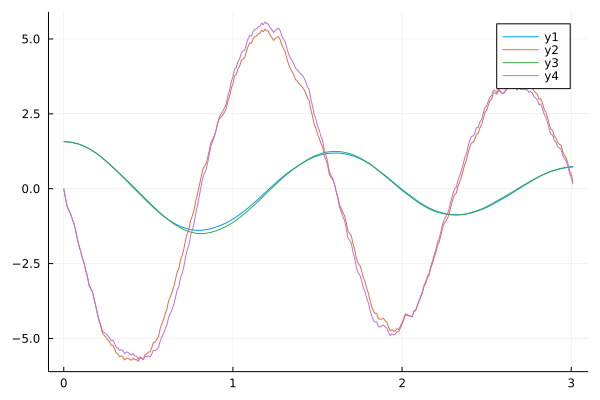

In [98]:
plot(time, theta_sim)
plot!(time, omega_sim)

plot!(time, theta_bilinear)
plot!(time, omega_bilinear)

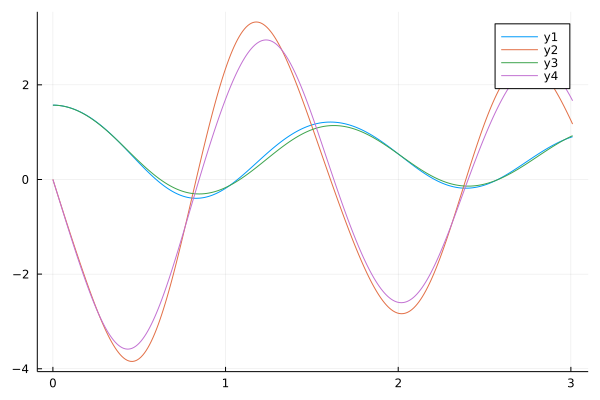

In [99]:
U_test = create_test_U(num_knots, m, "constant")

time_test, X_test = simulate(dmodel, x0, U_test, dt)
X_test_mat = mapreduce(permutedims, vcat, X_test)'

bi_X_test, _ = simulate_bilinear(F, C, g, x0, z0, U_test)
bi_X_test_mat = mapreduce(permutedims, vcat, bi_X_test)'

# extract individual state histories
theta_test_sim = X_test_mat[1, :]
omega_test_sim = X_test_mat[2, :]

theta_test_bilinear = bi_X_test_mat[1, :]
omega_test_bilinear = bi_X_test_mat[2, :]

plot(time_test, theta_test_sim)
plot!(time_test, omega_test_sim)

plot!(time_test, theta_test_bilinear)
plot!(time_test, omega_test_bilinear)

In [100]:
using FileIO, JLD2

FileIO.save("../../data/pendulum_eDMD_data.jld2", "F", F, "C", C, "g", g, "X_sim", X_sim, "U_sim", U_sim)